In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer



# Verificar si CUDA está disponible (no afectará el modelo de logistic regresion de sklearn, que corre en CPU)
if torch.cuda.is_available():
    print(f"CUDA está disponible. Usando la GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA no está disponible. Usando la CPU.")

# Aquí solo mostramos los CSV ya generados
print(" - train_data.csv")
print(" - val_data.csv")
print(" - test_data.csv")

# Cargar los tres dataset
train_data = pd.read_csv("divisonDatos/train_data.csv", sep=";")
val_data = pd.read_csv("divisonDatos/val_data.csv", sep=";")
test_data = pd.read_csv("divisonDatos/test_data.csv", sep=";")

train_data

CUDA no está disponible. Usando la CPU.
 - train_data.csv
 - val_data.csv
 - test_data.csv


,Label,Texto
0,0,rita maestre anuncia que en agosto llegarán 34...
1,0,psoe aclara que la mesa de negociación debe se...
2,0,campaña por la educación nueva propuesta legis...
3,1,educación y formación profesional destina más ...
4,1,la resurrección del presupuesto de andalucía y...
...,...,...
51988,0,nueva fórmula de alfonso guerra contra los par...
51989,0,el ministerio de sanidad lanza una campaña par...
51990,0,feijóo ensaya para las generales y moreno se s...
51991,0,el ministerio de educación anuncia nuevas medi...


Resultados en Entrenamiento:
Matriz de Confusión:
TP: 22473, TN: 22435, FP: 3661, FN: 3424
[[22435  3661]
 [ 3424 22473]]
Exactitud (Accuracy): 0.864
Precisión (Precision): 0.860
Especificidad (Specificity): 0.860
Sensibilidad (Recall/Sensitivity): 0.868
F1 Score: 0.864
--------------------------------------------------
Resultados en Validación:
Matriz de Confusión:
TP: 4301, TN: 3997, FP: 1424, FN: 1419
[[3997 1424]
 [1419 4301]]
Exactitud (Accuracy): 0.745
Precisión (Precision): 0.751
Especificidad (Specificity): 0.737
Sensibilidad (Recall/Sensitivity): 0.752
F1 Score: 0.752
--------------------------------------------------
Resultados en Prueba:
Matriz de Confusión:
TP: 4154, TN: 4141, FP: 1480, FN: 1367
[[4141 1480]
 [1367 4154]]
Exactitud (Accuracy): 0.744
Precisión (Precision): 0.737
Especificidad (Specificity): 0.737
Sensibilidad (Recall/Sensitivity): 0.752
F1 Score: 0.745
--------------------------------------------------


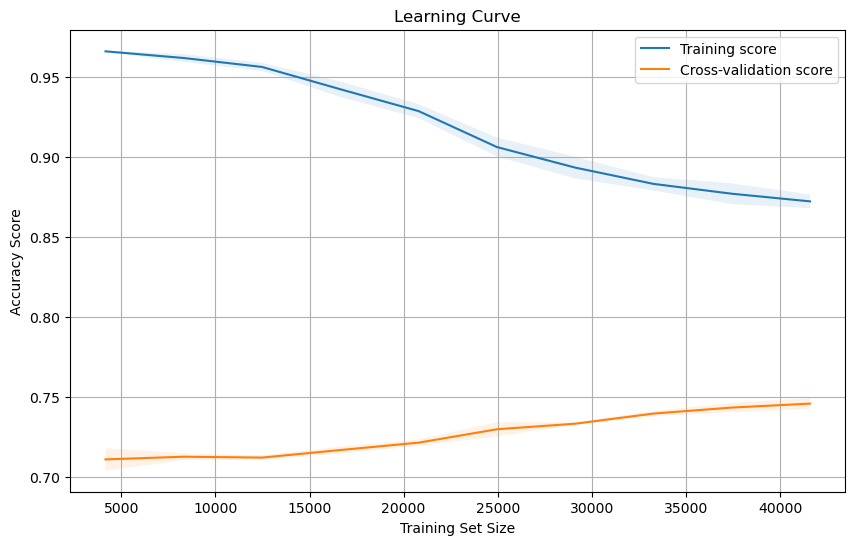

In [4]:
# Preprocesamiento mínimo: eliminar filas con valores nulos en Texto o Label
train_data = train_data.dropna(subset=['Texto', 'Label'])
val_data = val_data.dropna(subset=['Texto', 'Label'])
test_data = test_data.dropna(subset=['Texto', 'Label'])

X_train = train_data['Texto']
y_train = train_data['Label']

X_val = val_data['Texto']
y_val = val_data['Label']

X_test = test_data['Texto']
y_test = test_data['Label']

# Transformación del texto en vectores numéricos
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression() 
model.fit(X_train_vec, y_train)

def evaluar_modelo(X_data, y_true, subset_name=""):
    y_pred = model.predict(X_data)
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Resultados en {subset_name}:")
    print("Matriz de Confusión:")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(conf_matrix)
    print(f"Exactitud (Accuracy): {accuracy:.3f}")
    print(f"Precisión (Precision): {precision:.3f}")
    print(f"Especificidad (Specificity): {specificity:.3f}")
    print(f"Sensibilidad (Recall/Sensitivity): {sensitivity:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print("-"*50)

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training score")
    plt.plot(train_sizes, test_mean, label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_loss_curve():
    # Regresión logística (versión por defecto) no necesariamente guarda loss_curve_
    if hasattr(model, 'loss_curve_'):
        plt.figure(figsize=(10, 6))
        plt.plot(model.loss_curve_, label='Loss')
        plt.title("Loss Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

# Evaluar en entrenamiento, validación y prueba
evaluar_modelo(X_train_vec, y_train, subset_name="Entrenamiento")
evaluar_modelo(X_val_vec, y_val, subset_name="Validación")
evaluar_modelo(X_test_vec, y_test, subset_name="Prueba")

# Graficar la curva de aprendizaje
plot_learning_curve(model, X_train_vec, y_train)

# Graficar la curva de pérdida (si está disponible)
plot_loss_curve()

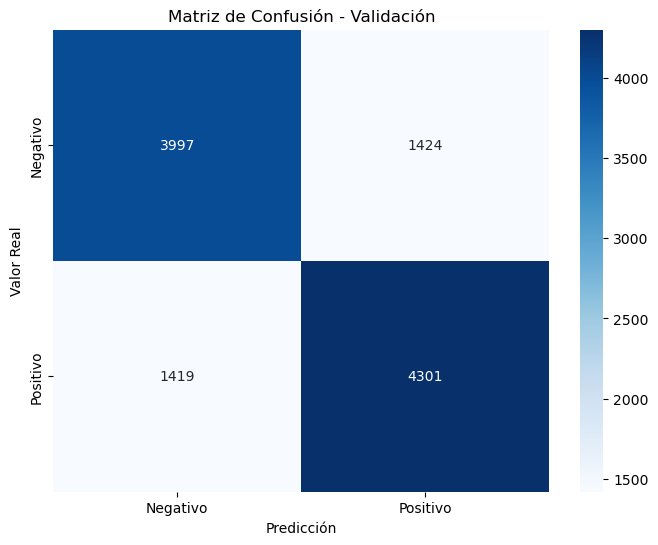

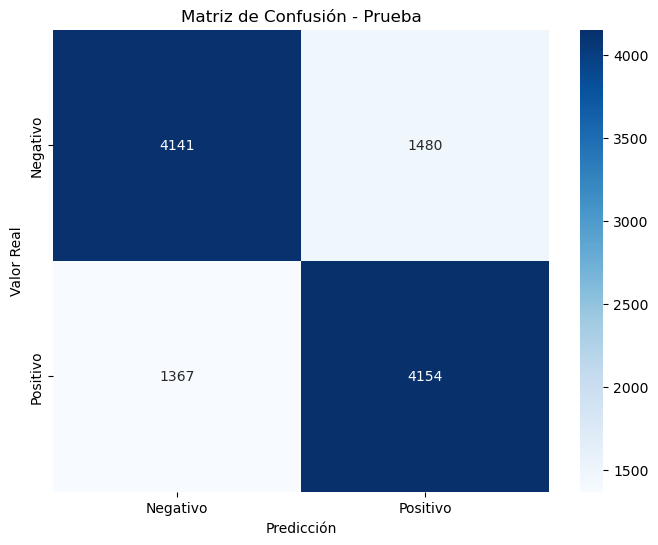

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, subset_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.title(f"Matriz de Confusión - {subset_name}")
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

# Predicciones para validación y prueba
y_val_pred = model.predict(X_val_vec)
y_test_pred = model.predict(X_test_vec)

# Graficar las matrices de confusión
plot_confusion_matrix(y_val, y_val_pred, subset_name="Validación")
plot_confusion_matrix(y_test, y_test_pred, subset_name="Prueba")
